In [1]:
import pandas as pd
import yaml
SOL_ROOT = '/home/ddon0001/PhD/experiments/scaled/no_div_constraint'
SCALES_PATH = '/home/ddon0001/PhD/data/cell_tracking_challenge/scales.yaml'

ds_summary = pd.read_csv(f'{SOL_ROOT}/summary.csv')
with open(SCALES_PATH, 'r') as f:
    scales = yaml.safe_load(f)

In [2]:
EDGE_FN = 'EdgeFlag.FALSE_NEG'
EDGE_FP = 'EdgeFlag.FALSE_POS'
EDGE_WS = 'EdgeFlag.WRONG_SEMANTIC'

NODE_FN = 'NodeFlag.FALSE_NEG'
NODE_FP = 'NodeFlag.FALSE_POS'
NODE_NS = 'NodeFlag.NON_SPLIT'

def has_adjacent_error_edges(sol, node):
    if any(sol[edge][EDGE_FP] or sol[edge][EDGE_WS] for edge in sol.in_edges(node)):
        return True
    if any(sol[edge][EDGE_FP] or sol[edge][EDGE_WS] for edge in sol.out_edges(node)):
        return True
    return False

In [3]:
from collections import defaultdict
import json
import os
import networkx as nx


should_terminate = defaultdict(list)
should_frame_skip = defaultdict(list)
should_migrate = defaultdict(list)
should_migrate_to_fn = defaultdict(list)
should_divide = defaultdict(list)
should_be_erased = defaultdict(list)
total_fn = defaultdict(lambda : 0)
total_edges = defaultdict(lambda : 0)
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    gt_solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_gt.graphml')
    solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_solution.graphml')
    node_match_path = os.path.join(SOL_ROOT, ds_name, 'matching.json')
    
    gt_g = nx.read_graphml(gt_solution_path)
    sol_g = nx.read_graphml(solution_path, node_type=int)
    with open(node_match_path) as f:
        node_match = json.load(f)
    gt_to_sol = {item[0]: item[1] for item in node_match}
    sol_to_gt = {item[1]: item[0] for item in node_match}

    total_fn[ds_name] = len([node for node in gt_g.nodes if gt_g.nodes[node][NODE_FN]])
    for node in sol_g.nodes:
        # we have a merge vertex
        if sol_g.in_degree(node) > 1:
            parents = sol_g.predecessors(node)
            node_gt = sol_to_gt[node]
            fp_parents = []
            for parent in parents:
                edge_of_interest = (parent, node)
                # this edge doesn't exist in gt
                if sol_g.edges[edge_of_interest][EDGE_FP]:
                    fp_parents.append(parent)
                    total_edges[ds_name] += 1
                    # so what does gt_parent usually do?
                    gt_parent = sol_to_gt[parent]
                    gt_kids = list(gt_g.successors(gt_parent))
                    n_kids = len(gt_kids)
                    if n_kids == 0:
                        # "parent" should be terminating
                        should_terminate[ds_name].append(parent)
                        continue
                    elif n_kids == 1:
                        kid = gt_kids[0]
                        if gt_g.nodes[kid]['t'] > gt_g.nodes[gt_parent]['t'] + 1:
                            # "parent" is frame skipping
                            should_frame_skip[ds_name].append(parent)
                            continue
                        else:
                            # we're missing this vertex
                            if gt_g.nodes[kid][NODE_FN]:
                                should_migrate_to_fn[ds_name].append(parent)
                                continue
                            else:
                                # "parent" should be migrating normally elsewhere
                                should_migrate[ds_name].append(parent)
                                continue
                    else:
                        raise ValueError(f'{ds_name} {parent} should divide but is merging.')
                    #     # parent is splitting into two totally different children
                    #     should_divide[ds_name].append(parent)
            if len(fp_parents) > 1:
                # all parents are false positives!
                should_be_erased[ds_name].append(node)
                

In [4]:
# FP edges flowing into merge nodes
ds_names = []
count_erase = []
count_term = []
count_mig = []
count_fn = []
count_total_fn = []
count_skip = []
count_edges = []
for key in ds_summary['ds_name']:
    ds_names.append(key)
    count_term.append(len(should_terminate[key]))
    count_erase.append(len(should_be_erased[key]))
    count_mig.append(len(should_migrate[key]))
    count_fn.append(len(should_migrate_to_fn[key]))
    count_total_fn.append(total_fn[key])
    count_skip.append(len(should_frame_skip[key]))
    count_edges.append(total_edges[key])
fp_summary = pd.DataFrame({
    'ds_name': ds_names,
    'erase': count_erase,
    'total_fn': count_total_fn,
    'fn': count_fn,
    'term': count_term,
    'skip': count_skip,
    'mig': count_mig,
    'fp_edges': count_edges 
})
sorted_fp = fp_summary.sort_values(by='fp_edges')
sorted_fp[sorted_fp.fp_edges > 0]

,ds_name,erase,total_fn,fn,term,skip,mig,fp_edges
0,Fluo-C3DL-MDA231_01,0,13,1,0,0,0,1
18,BF-C2DL-HSC_01,0,1,1,0,0,0,1
2,Fluo-N2DH-GOWT1_01,0,4,1,1,1,0,3
1,Fluo-C3DL-MDA231_02,0,3,0,4,0,0,4
19,BF-C2DL-HSC_02,0,2,2,0,1,1,4
3,Fluo-N2DH-GOWT1_02,0,230,6,3,1,0,10
6,Fluo-N2DL-HeLa_01,0,37,11,3,0,1,15
24,Fluo-N3DH-CE_01,1,17,13,0,0,3,16
25,Fluo-N3DH-CE_02,0,101,27,2,0,2,31
7,Fluo-N2DL-HeLa_02,0,42,13,14,0,5,32


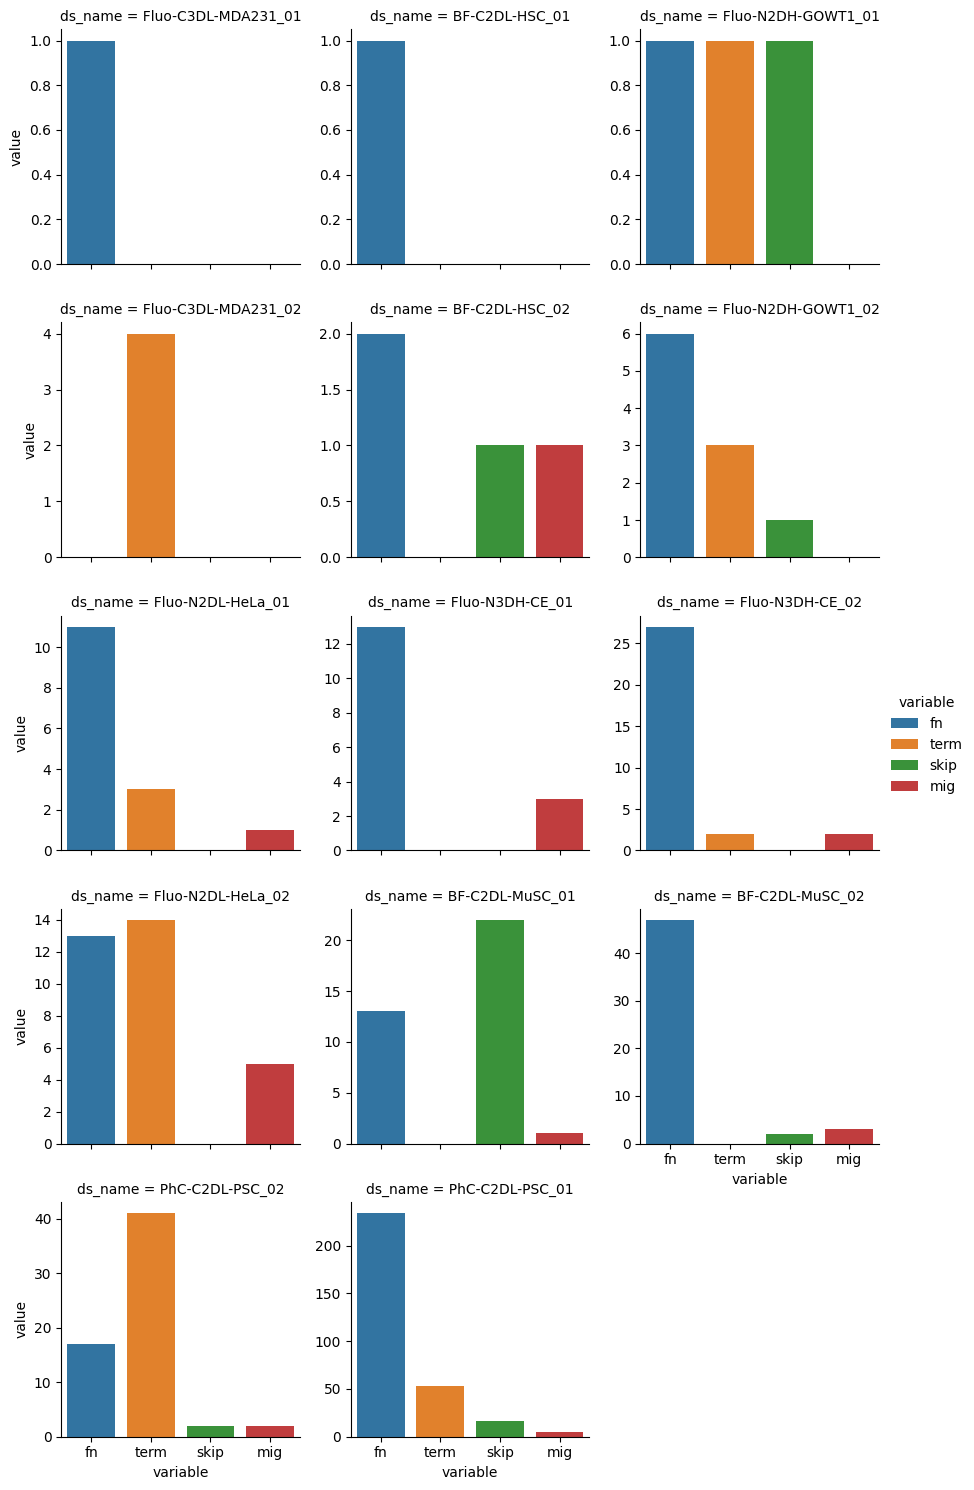

In [5]:
import seaborn as sns

fp_edges_melted = sorted_fp[sorted_fp.fp_edges>0].melt(id_vars='ds_name', value_vars=['fn', 'term', 'skip', 'mig'])
grid = sns.FacetGrid(fp_edges_melted, col='ds_name', col_wrap=3, sharex=True, sharey=False, legend_out=True, hue='variable')
grid.map_dataframe(sns.barplot, x='variable', y='value')
grid.add_legend()


In [6]:
# how many skip frames have we "correctly" captured through merge and split?
from collections import defaultdict
import json
import os
import networkx as nx

ds_names = []
count_skip = []
count_fn_adjacent = []
count_correctly_merged = []
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    gt_solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_gt.graphml')
    solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_solution.graphml')
    node_match_path = os.path.join(SOL_ROOT, ds_name, 'matching.json')
    
    gt_g = nx.read_graphml(gt_solution_path)
    sol_g = nx.read_graphml(solution_path, node_type=int)

    with open(node_match_path) as f:
        node_match = json.load(f)
    gt_to_sol = {item[0]: item[1] for item in node_match}
    sol_to_gt = {item[1]: item[0] for item in node_match}

    skip_edges = [edge for edge in gt_g.edges if gt_g.nodes[edge[0]]['t'] < gt_g.nodes[edge[1]]['t'] - 1]
    count_correct = 0
    count_fn = 0
    for edge in skip_edges:
        if edge[0] not in gt_to_sol or edge[1] not in gt_to_sol:
            count_fn += 1
            continue
        sol_parent = gt_to_sol[edge[0]]
        sol_child = gt_to_sol[edge[1]]
        # we want parent to be flowing into a merge
        if sol_g.out_degree(sol_parent) == 1:
            successor = list(sol_g.successors(sol_parent))[0]
            if sol_g.in_degree(successor) > 1:
                # sol_parent is flowing into a merge - follow the merge to its end
                v = successor
                children = list(sol_g.successors(v))
                while len(children) == 1:
                    v = children[0]
                    children = list(sol_g.successors(v))
                # we've either split or we've terminated
                if len(children) > 1:
                    # we've split - are any of the children sol_child?
                    if any(child == sol_child for child in children):
                        count_correct += 1
    ds_names.append(ds_name)
    count_correctly_merged.append(count_correct)
    count_skip.append(len(skip_edges))
    count_fn_adjacent.append(count_fn)
skip_merges = pd.DataFrame({
    'ds_name': ds_names,
    'total_skips': count_skip,
    'fn_adjacent': count_fn_adjacent,
    'total_correct': count_correctly_merged
})


In [7]:
skip_merges

,ds_name,total_skips,fn_adjacent,total_correct
0,Fluo-C3DL-MDA231_01,0,0,0
1,Fluo-C3DL-MDA231_02,1,0,0
2,Fluo-N2DH-GOWT1_01,2,0,1
3,Fluo-N2DH-GOWT1_02,11,11,0
4,PhC-C2DH-U373_01,1,0,0
5,PhC-C2DH-U373_02,5,0,0
6,Fluo-N2DL-HeLa_01,0,0,0
7,Fluo-N2DL-HeLa_02,3,0,0
8,Fluo-C2DL-MSC_01,0,0,0
9,Fluo-C2DL-MSC_02,0,0,0


In [8]:
skip_merges.to_csv(os.path.join(SOL_ROOT, 'skip_merges.csv'))

In [9]:
# how many merges correctly fuel divisions?

ds_names = []
total_merges = []
# looking at the fate of the merge now
count_correct_division = []
count_incorrect_division = []
count_terminating_correct = []
count_terminating_incorrect = []
total_explained = []
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    gt_solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_gt.graphml')
    solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_solution.graphml')
    node_match_path = os.path.join(SOL_ROOT, ds_name, 'matching.json')
    
    gt_g = nx.read_graphml(gt_solution_path)
    sol_g = nx.read_graphml(solution_path, node_type=int)

    with open(node_match_path) as f:
        node_match = json.load(f)
    gt_to_sol = {item[0]: item[1] for item in node_match}
    sol_to_gt = {item[1]: item[0] for item in node_match}

    merges = [node for node in sol_g.nodes if sol_g.in_degree(node) > 1]
    total = len(merges)
    n_correct = 0
    n_incorrect = 0
    n_terminating_correct = 0
    n_terminating_incorrect = 0

    for merge_node in merges:
        children = list(sol_g.successors(merge_node))
        v = merge_node
        while len(children) == 1:
            v = children[0]
            children = list(sol_g.successors(v))
        if len(children) == 0:
            gt_term = sol_to_gt[v]
            # gt node also terminates
            if len(list(gt_g.successors(gt_term))) == 0:
                n_terminating_correct += 1
            else:
                n_terminating_incorrect += 1
        elif len(children) > 1:
            div_edges = [(v, child) for child in children]
            # are any edges wrong?
            if any(sol_g.edges[edge][EDGE_FP] or sol_g.edges[edge][EDGE_WS] for edge in div_edges):
                n_incorrect += 1
            else:
                n_correct += 1
    ds_names.append(ds_name)
    total_merges.append(total)
    count_correct_division.append(n_correct)
    count_incorrect_division.append(n_incorrect)
    count_terminating_correct.append(n_terminating_correct)
    count_terminating_incorrect.append(n_terminating_incorrect)
    total_explained.append(n_correct + n_incorrect + n_terminating_correct + n_terminating_incorrect)
merge_fates = pd.DataFrame({
    'ds_name': ds_names,
    'total_merges': total_merges,
    'total_explained': total_explained,
    'correct_division': count_correct_division,
    'incorrect_division': count_incorrect_division,
    'terminating_correct': count_terminating_correct,
    'terminating_incorrect': count_terminating_incorrect,
})


In [10]:
merge_fates[merge_fates['total_merges'] > 0] 

,ds_name,total_merges,total_explained,correct_division,incorrect_division,terminating_correct,terminating_incorrect
0,Fluo-C3DL-MDA231_01,1,1,0,0,1,0
1,Fluo-C3DL-MDA231_02,4,4,0,0,4,0
2,Fluo-N2DH-GOWT1_01,3,3,0,2,1,0
3,Fluo-N2DH-GOWT1_02,10,10,0,7,3,0
6,Fluo-N2DL-HeLa_01,15,15,3,12,0,0
7,Fluo-N2DL-HeLa_02,32,32,1,20,11,0
16,BF-C2DL-MuSC_01,34,34,0,34,0,0
17,BF-C2DL-MuSC_02,49,49,0,48,1,0
18,BF-C2DL-HSC_01,1,1,0,1,0,0
19,BF-C2DL-HSC_02,4,4,0,4,0,0


In [11]:
# symmetry/asymmetry of divisions 
import numpy as np


div_diff_dict = {
    'ds_name': [],
    'div_parent_index': [],
    'is_correct': [],
    'is_superparent': [],
    'child_distance_1': [],
    'child_distance_2': [],
    'child_distance_difference': [],
    'interchild_distance': [],
    'div_angle': []
}

# WE TAKE TWO CLOSEST CHILDREN
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_solution.graphml')
    
    sol_g = nx.read_graphml(solution_path, node_type=int)
    location_cols = ['z', 'y', 'x'] if 'z' in sol_g.nodes[0] else ['y', 'x']
    scale = scales[ds_name]['pixel_scale']

    divs = [node for node in sol_g.nodes if sol_g.out_degree(node) > 1]
    for div in divs:
        children = list(sol_g.successors(div))
        is_superparent = len(children) > 2
        is_correct = not any(sol_g.edges[(div, child)][EDGE_FP] or sol_g.edges[(div, child)][EDGE_WS] for child in children)
        parent_coords = np.asarray([sol_g.nodes[div][col] * scale[i] for i, col in enumerate(location_cols)])
        child_coords = [np.asarray([sol_g.nodes[child][col] * scale[i] for i, col in enumerate(location_cols)]) for child in children]
        child_distances = [np.linalg.norm(parent_coords - child) for child in child_coords]
        dist_indices = np.argsort(child_distances)
        closest_children = [child_coords[i] for i in dist_indices[:2]]
        distances = [child_distances[i] for i in dist_indices[:2]]
        div_angle = np.degrees(np.arccos(
            np.dot(closest_children[0] - parent_coords, closest_children[1] - parent_coords) /
            (distances[0] * distances[1])
        ))
    
        div_diff_dict['ds_name'].append(ds_name)
        div_diff_dict['div_parent_index'].append(div)
        div_diff_dict['is_correct'].append(is_correct)
        div_diff_dict['is_superparent'].append(is_superparent)
        div_diff_dict['child_distance_1'].append(distances[0])
        div_diff_dict['child_distance_2'].append(distances[1])
        div_diff_dict['child_distance_difference'].append(distances[1] - distances[0])
        div_diff_dict['interchild_distance'].append(np.linalg.norm(closest_children[0] - closest_children[1]))
        div_diff_dict['div_angle'].append(div_angle)

div_diff_df = pd.DataFrame(div_diff_dict)

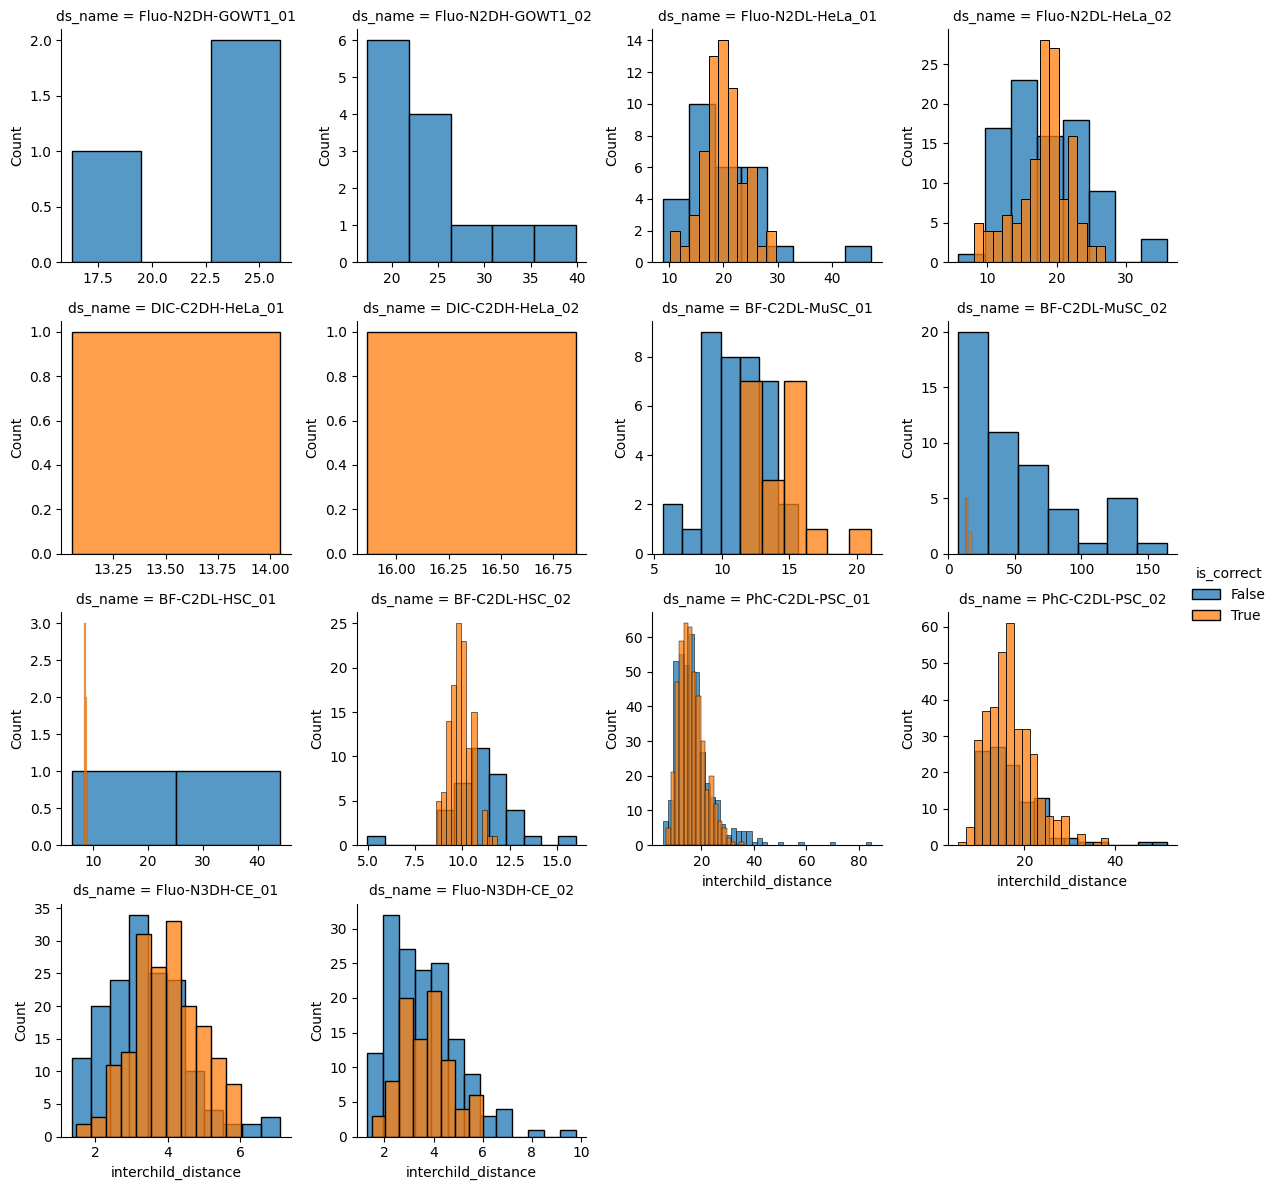

In [12]:
import seaborn as sns

grid = sns.FacetGrid(div_diff_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='is_correct')
grid.map_dataframe(sns.histplot, x='interchild_distance')
grid.add_legend()

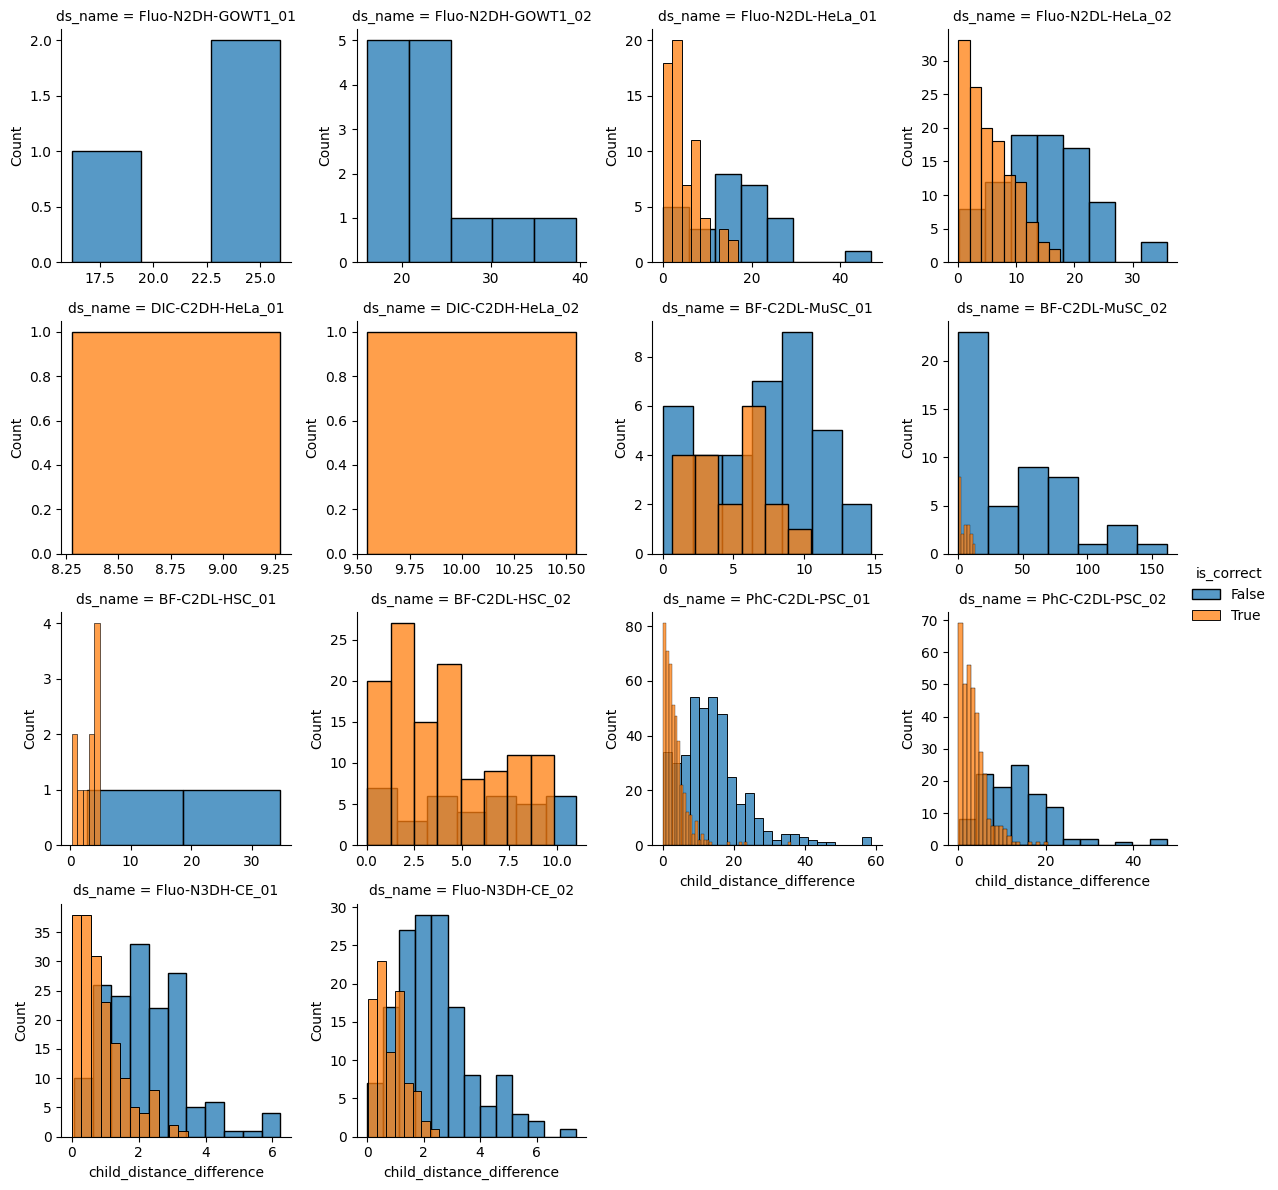

In [13]:
import seaborn as sns

grid = sns.FacetGrid(div_diff_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='is_correct')
grid.map_dataframe(sns.histplot, x='child_distance_difference')
grid.add_legend()

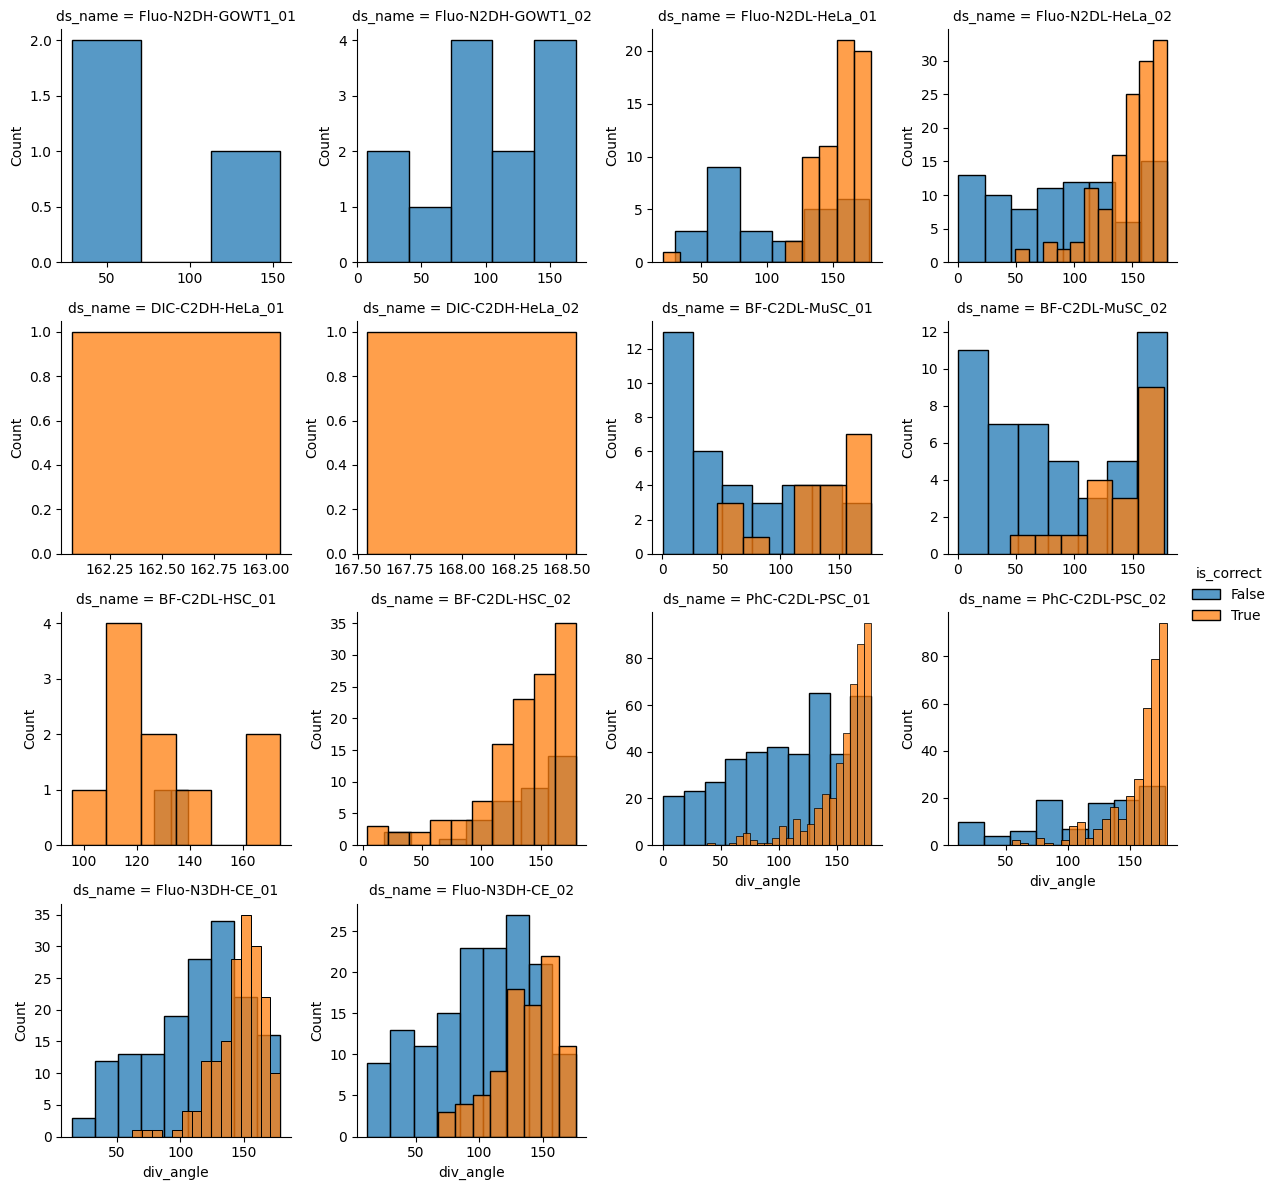

In [14]:
import seaborn as sns

grid = sns.FacetGrid(div_diff_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='is_correct')
grid.map_dataframe(sns.histplot, x='div_angle')
grid.add_legend()

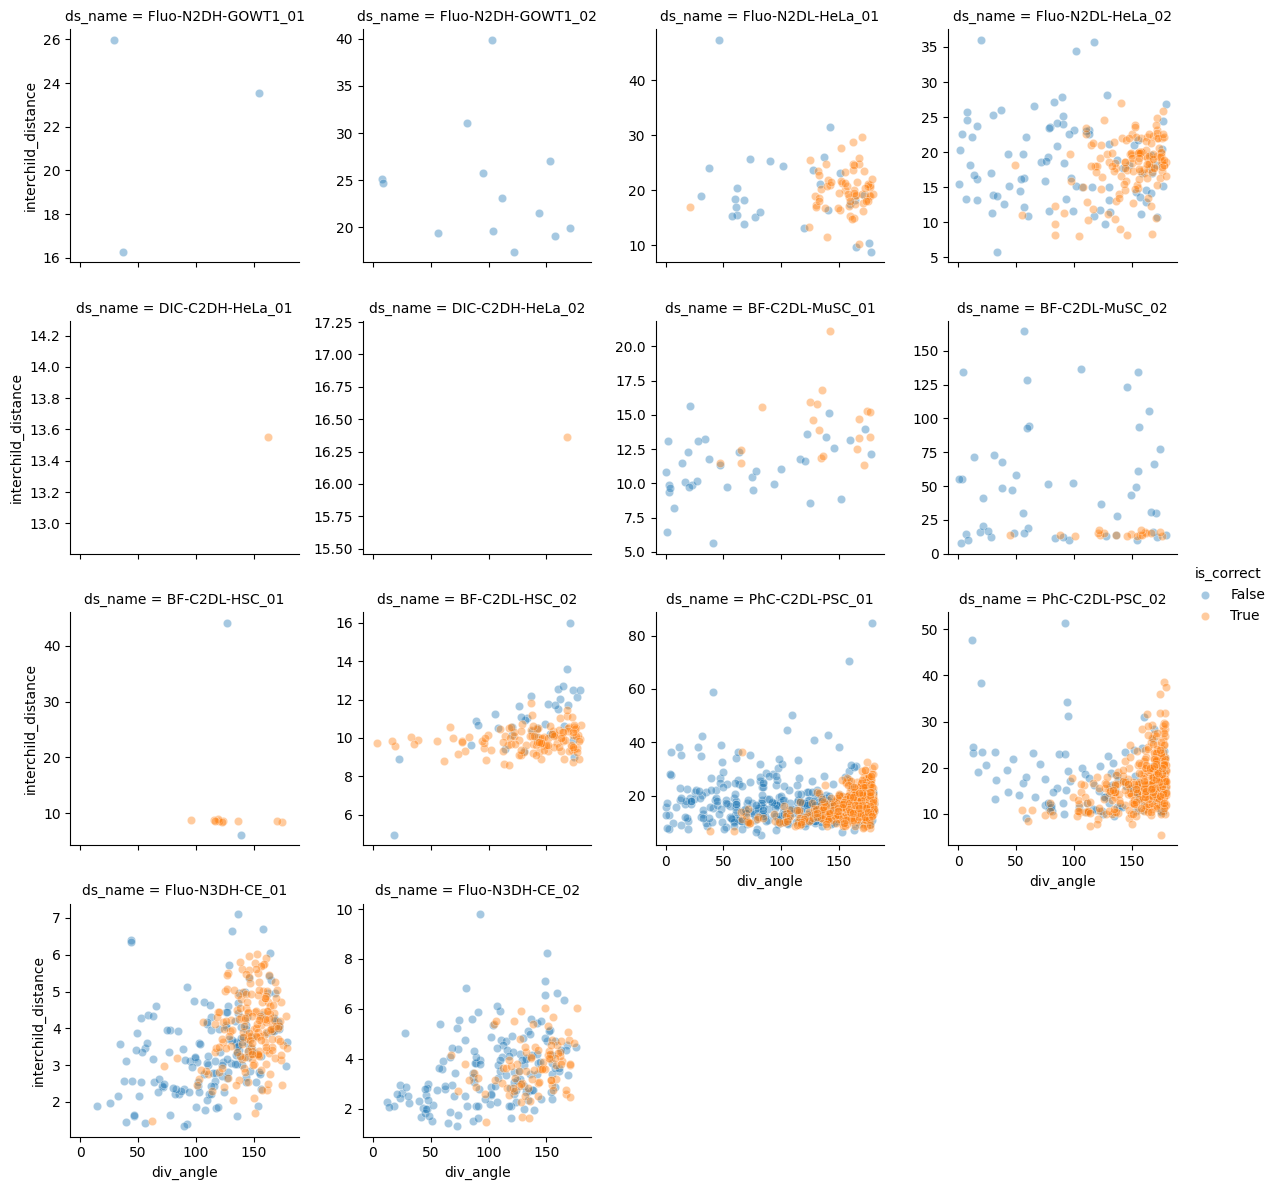

In [15]:
import seaborn as sns

grid = sns.FacetGrid(div_diff_df, col='ds_name', col_wrap=4, sharex=True, sharey=False, legend_out=True, hue='is_correct')
grid.map_dataframe(sns.scatterplot, x='div_angle', y='interchild_distance', alpha=0.4)
grid.add_legend()

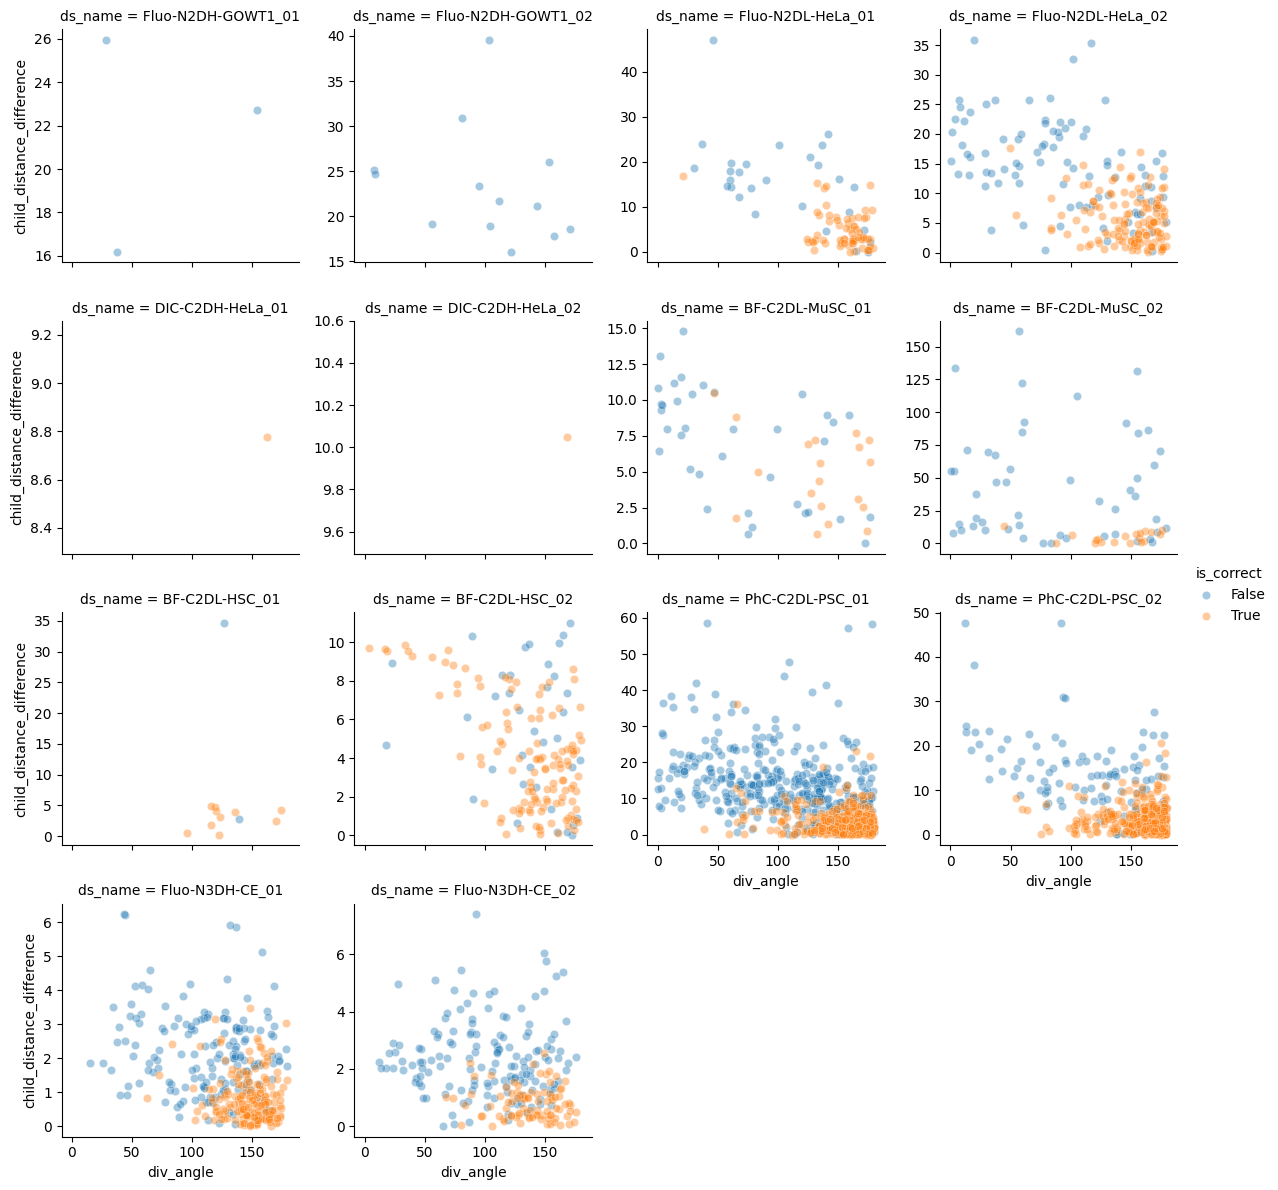

In [16]:
import seaborn as sns

grid = sns.FacetGrid(div_diff_df, col='ds_name', col_wrap=4, sharex=True, sharey=False, legend_out=True, hue='is_correct')
grid.map_dataframe(sns.scatterplot, x='div_angle', y='child_distance_difference', alpha=0.4)
grid.add_legend()

In [17]:
import os
import networkx as nx

# which kth neighbour is chosen for correct migration/incorrect migration
# which kth neighbours are chosen for correct division vs. incorrect division
kth_neighbour_dict = {
    'ds_name': [],
    'source_v': [],
    'dest_v': [],
    'edge_correct': [],
    'neighbour_rank': []
}
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_solution.graphml')
    all_edges_path = os.path.join(SOL_ROOT, ds_name, 'all_edges.csv')
    
    gt_g = nx.read_graphml(solution_path, node_type=int)
    all_edges = pd.read_csv(all_edges_path)
    location_cols = ['z', 'y', 'x'] if 'z' in gt_g.nodes[0] else ['y', 'x']
    scale = scales[ds_name]['pixel_scale']

    for edge in gt_g.edges:
        source = edge[0]
        dest = edge[1]
        edge_correct = not (gt_g.edges[edge][EDGE_FP] or gt_g.edges[edge][EDGE_WS])

        other_edges = all_edges[(all_edges['u'] == source) & (all_edges['v'] >= 0)].sort_values(by='distance').reset_index()
        neighbour_rank = other_edges[other_edges['v'] == dest].index[0]
        kth_neighbour_dict['ds_name'].append(ds_name)
        kth_neighbour_dict['source_v'].append(source)
        kth_neighbour_dict['dest_v'].append(dest)
        kth_neighbour_dict['edge_correct'].append(edge_correct)
        kth_neighbour_dict['neighbour_rank'].append(neighbour_rank)
kth_neighbour_df = pd.DataFrame(kth_neighbour_dict)

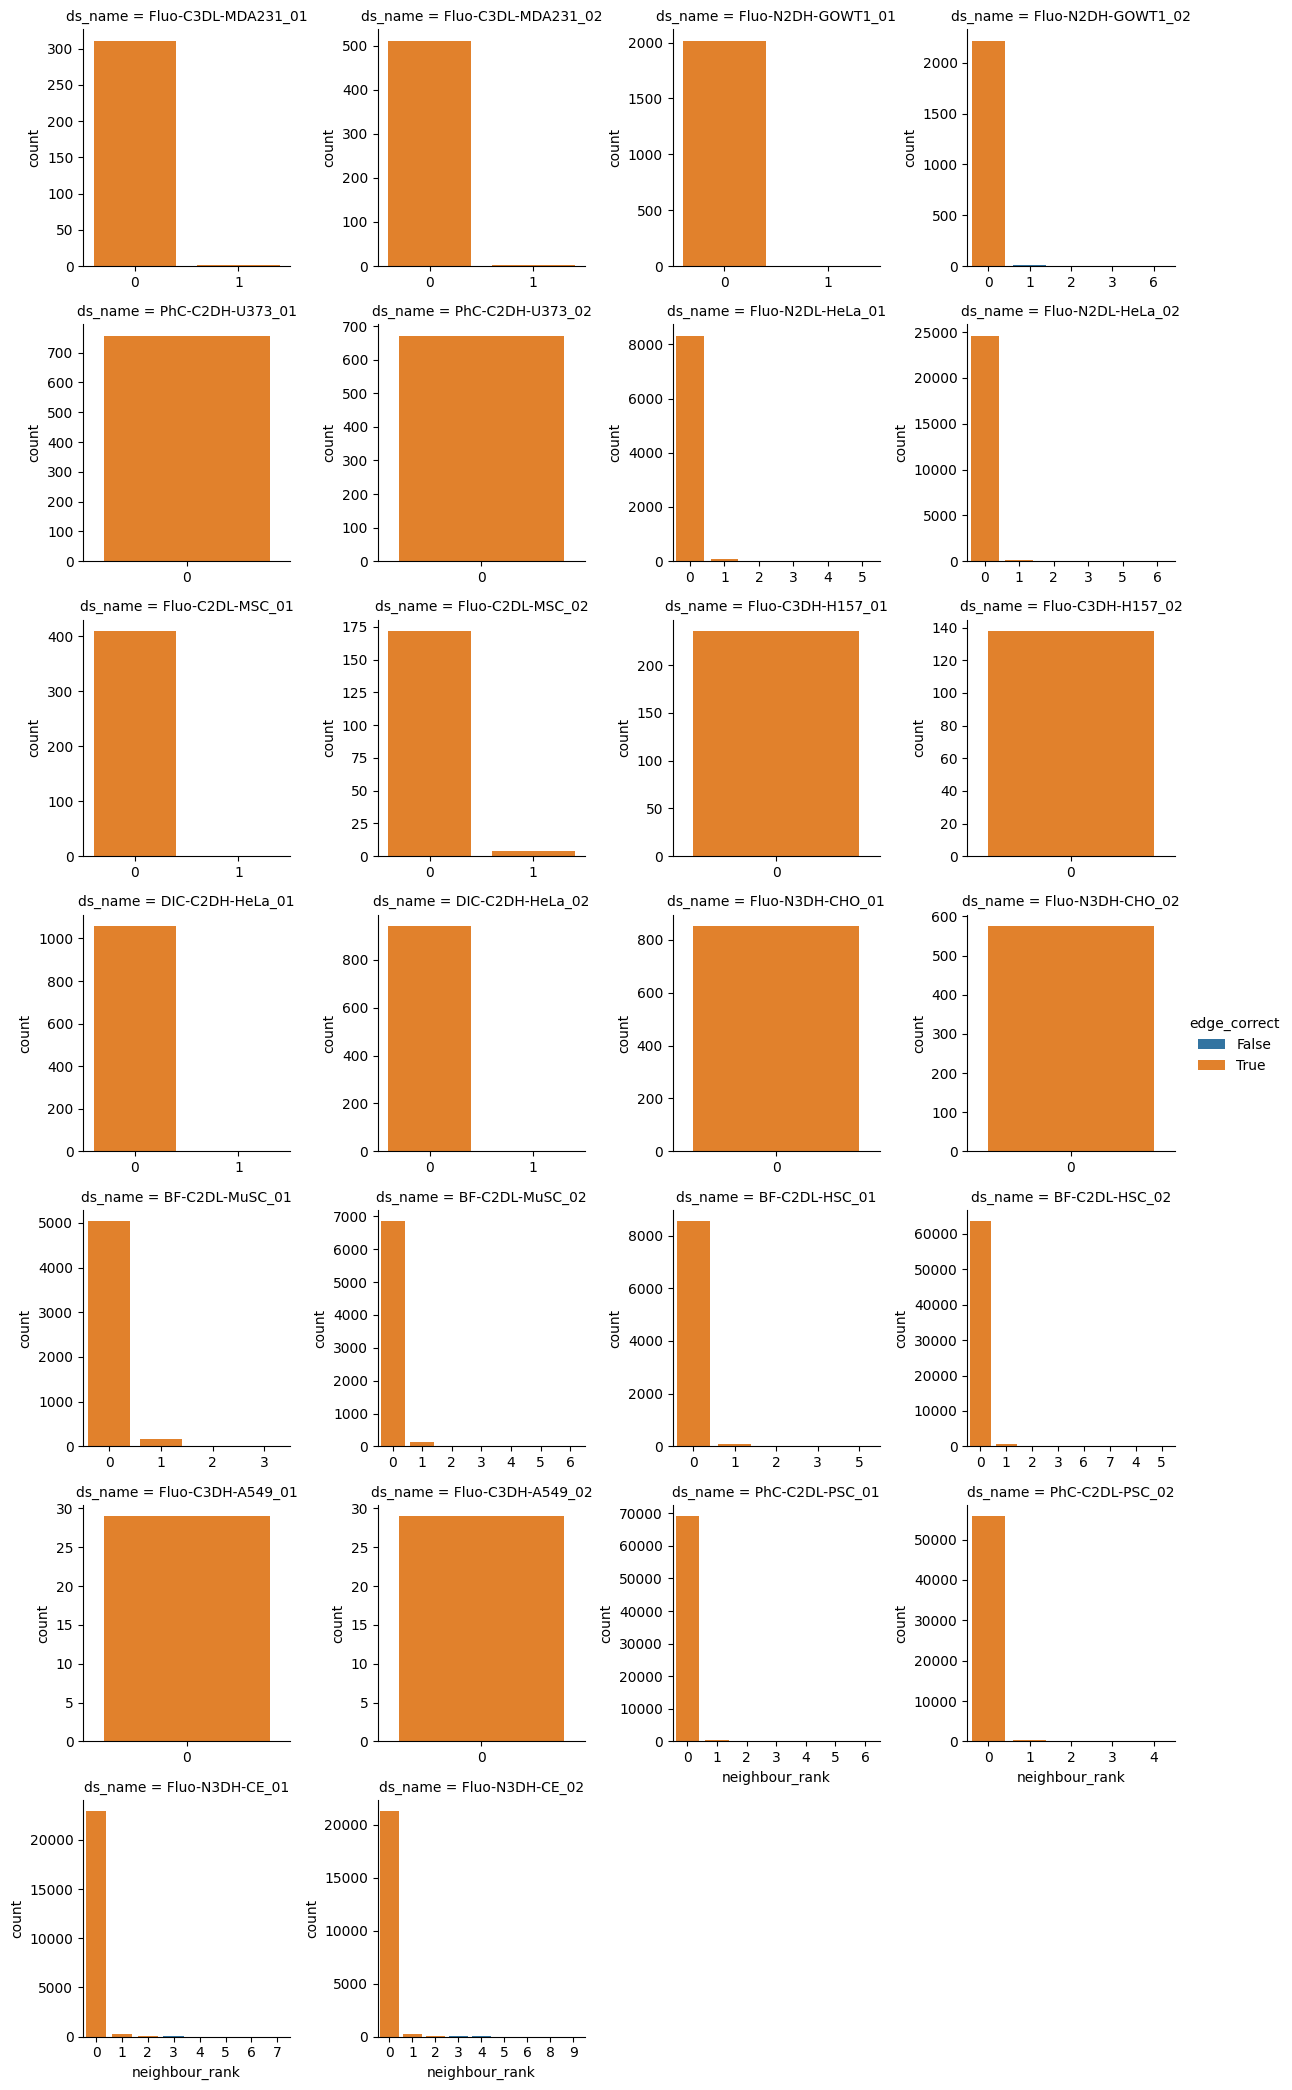

In [18]:
import seaborn as sns

grid = sns.FacetGrid(kth_neighbour_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='edge_correct')
grid.map_dataframe(sns.countplot, x='neighbour_rank')
grid.add_legend()

/home/ddon0001/miniconda3/envs/trexp/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ddon0001/miniconda3/envs/trexp/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ddon0001/miniconda3/envs/trexp/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ddon0001/miniconda3/envs/trexp/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated a

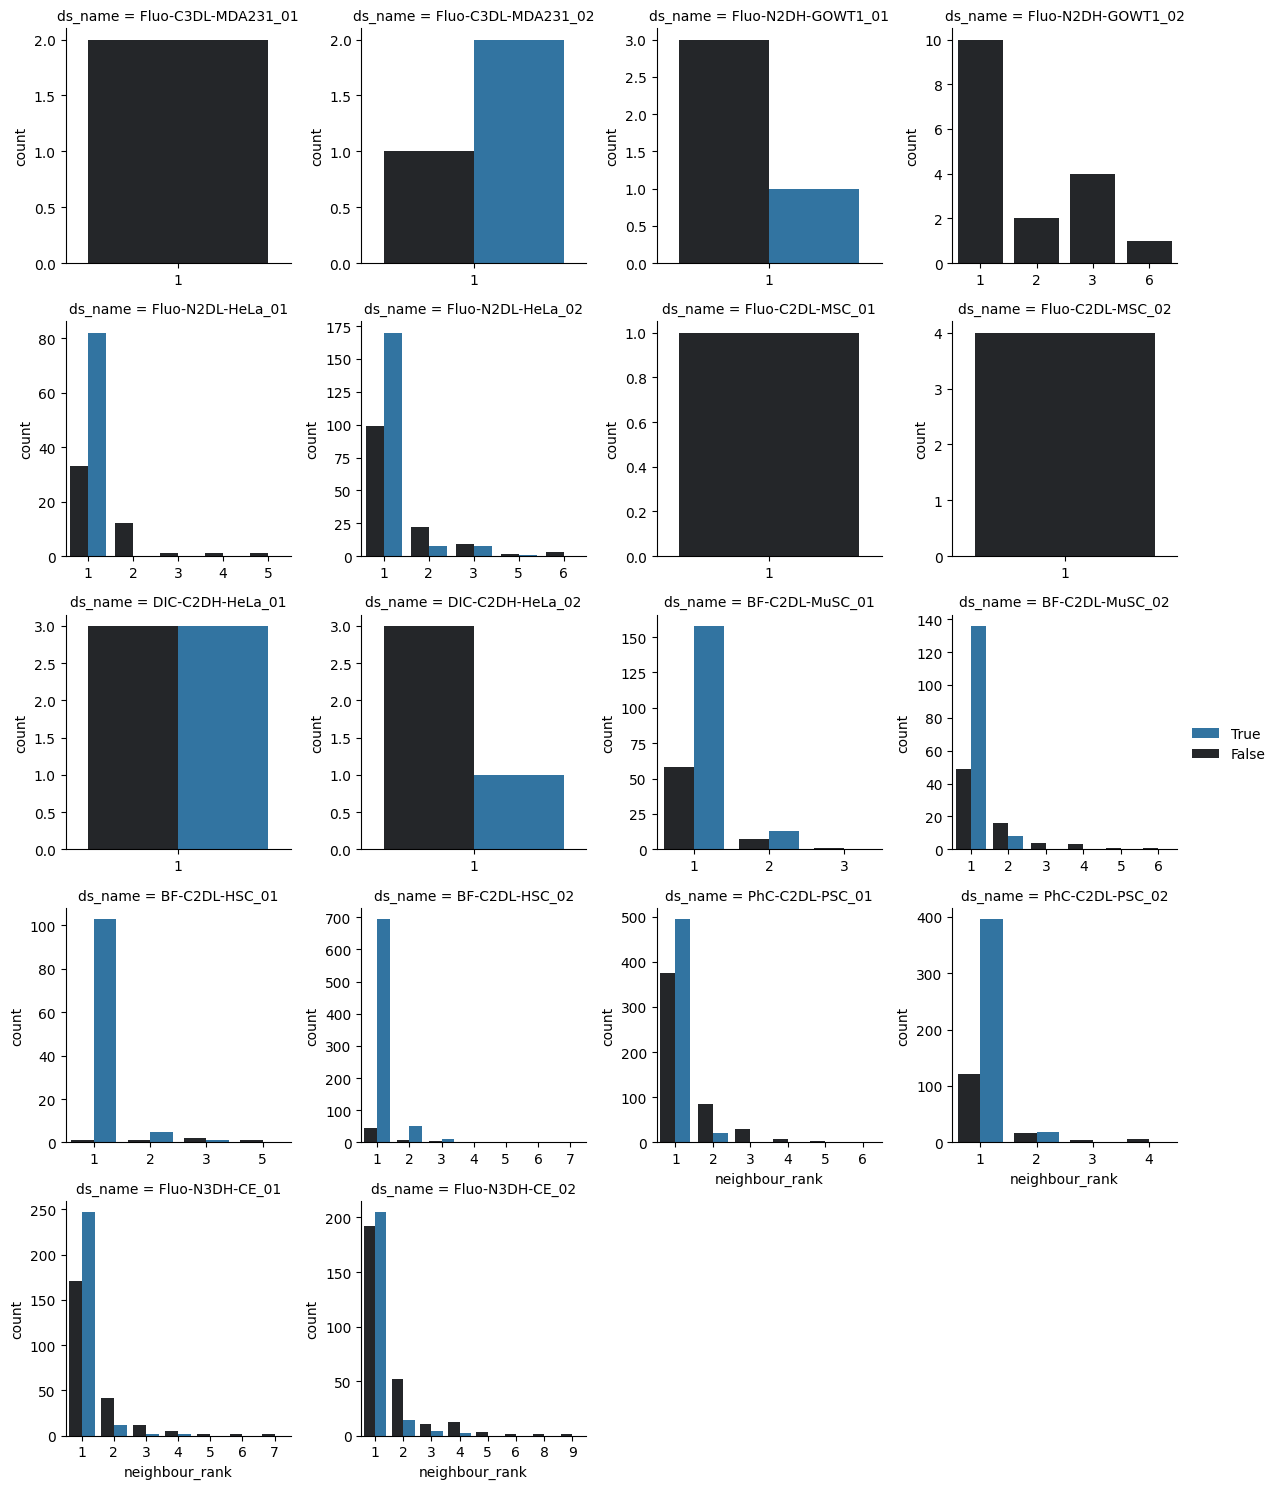

In [19]:
import seaborn as sns

no_zeros = kth_neighbour_df[kth_neighbour_df['neighbour_rank'] > 0]
grid = sns.FacetGrid(no_zeros, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True)
grid.map_dataframe(sns.countplot, x='neighbour_rank', hue='edge_correct')
grid.add_legend()

In [20]:
# gt neighbour rank
import os
import networkx as nx
import pandas as pd
import numpy as np
import json

GT_ROOT =  '/home/ddon0001/PhD/experiments/scaled/gt_no_div_constraint'
kth_neighbour_dict = {
    'ds_name': [],
    'source_v': [],
    'dest_v': [],
    'neighbour_rank': []
}
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    solution_path = os.path.join(GT_ROOT, ds_name, 'matched_gt.graphml')
    matching_path = os.path.join(GT_ROOT, ds_name, 'matching.json')
    all_edges_path = os.path.join(GT_ROOT, ds_name, 'all_edges.csv')
    
    gt_g = nx.read_graphml(solution_path)
    all_edges = pd.read_csv(all_edges_path)
    location_cols = ['x', 'y', 'z'] if 'z' in gt_g.nodes[list(gt_g.nodes)[0]] else ['x', 'y']

    with open(matching_path) as f:
        node_match = json.load(f)
    gt_to_sol = {item[0]: item[1] for item in node_match}
    sol_to_gt = {item[1]: item[0] for item in node_match}

    for edge in gt_g.edges:
        source = edge[0]
        dest = edge[1]

        sol_source = gt_to_sol[source]
        sol_dest = gt_to_sol[dest]
        other_edges = all_edges[(all_edges['u'] == sol_source) & (all_edges['v'] >= 0)].sort_values(by='distance').reset_index()
        v_edge = other_edges[other_edges['v'] == sol_dest]
        if v_edge.empty:
            neighbour_rank = -1
        else:
            neighbour_rank = v_edge.index[0]
        kth_neighbour_dict['ds_name'].append(ds_name)
        kth_neighbour_dict['source_v'].append(sol_source)
        kth_neighbour_dict['dest_v'].append(sol_dest)
        kth_neighbour_dict['neighbour_rank'].append(neighbour_rank)
gt_neighbour_rank_df = pd.DataFrame(kth_neighbour_dict)

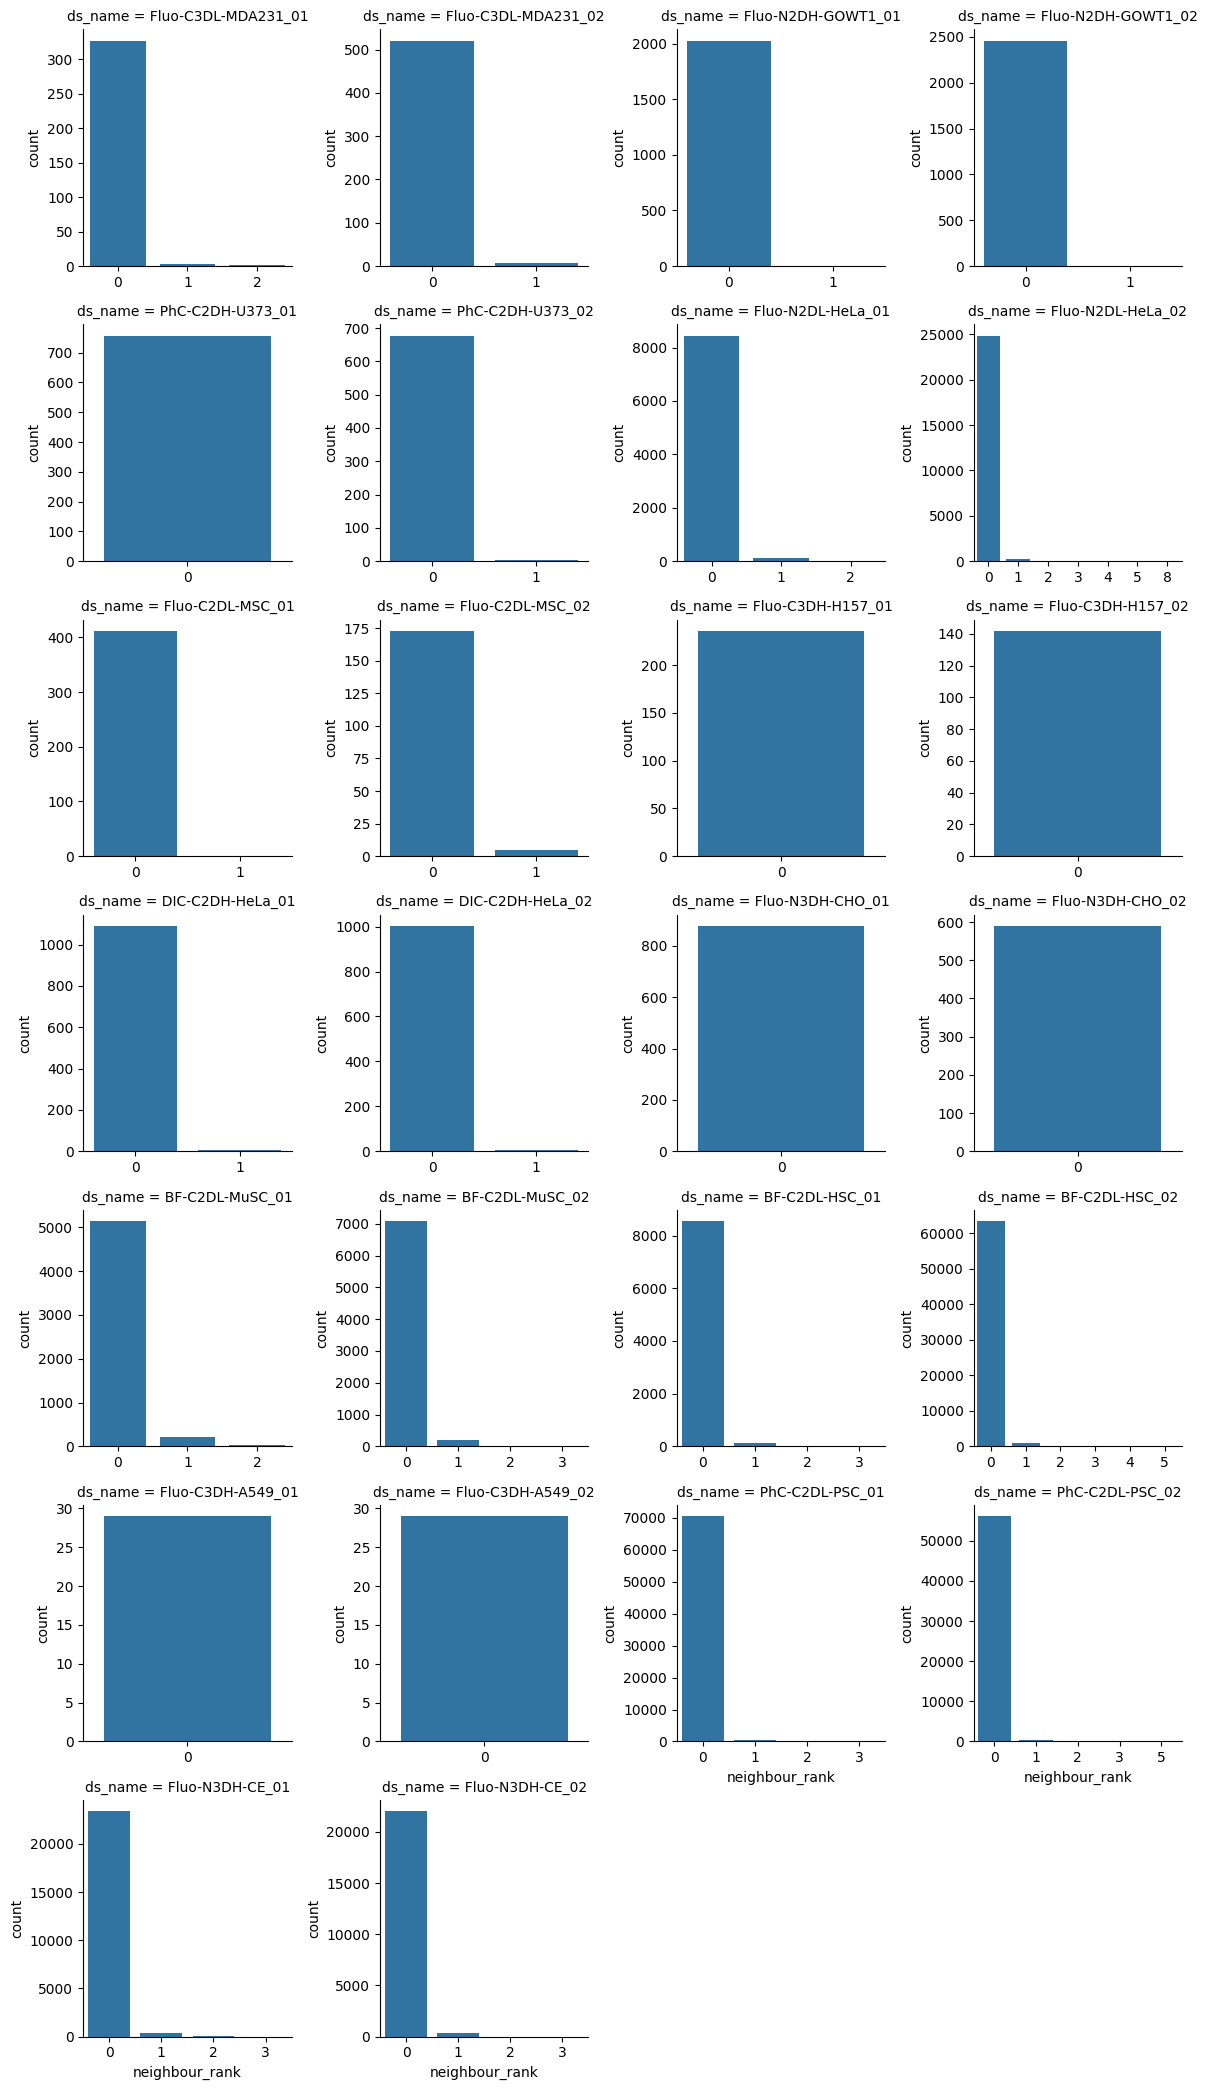

In [21]:
import seaborn as sns

grid = sns.FacetGrid(gt_neighbour_rank_df[gt_neighbour_rank_df['neighbour_rank'] >= 0], col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True)
grid.map_dataframe(sns.countplot, x='neighbour_rank')
grid.add_legend()

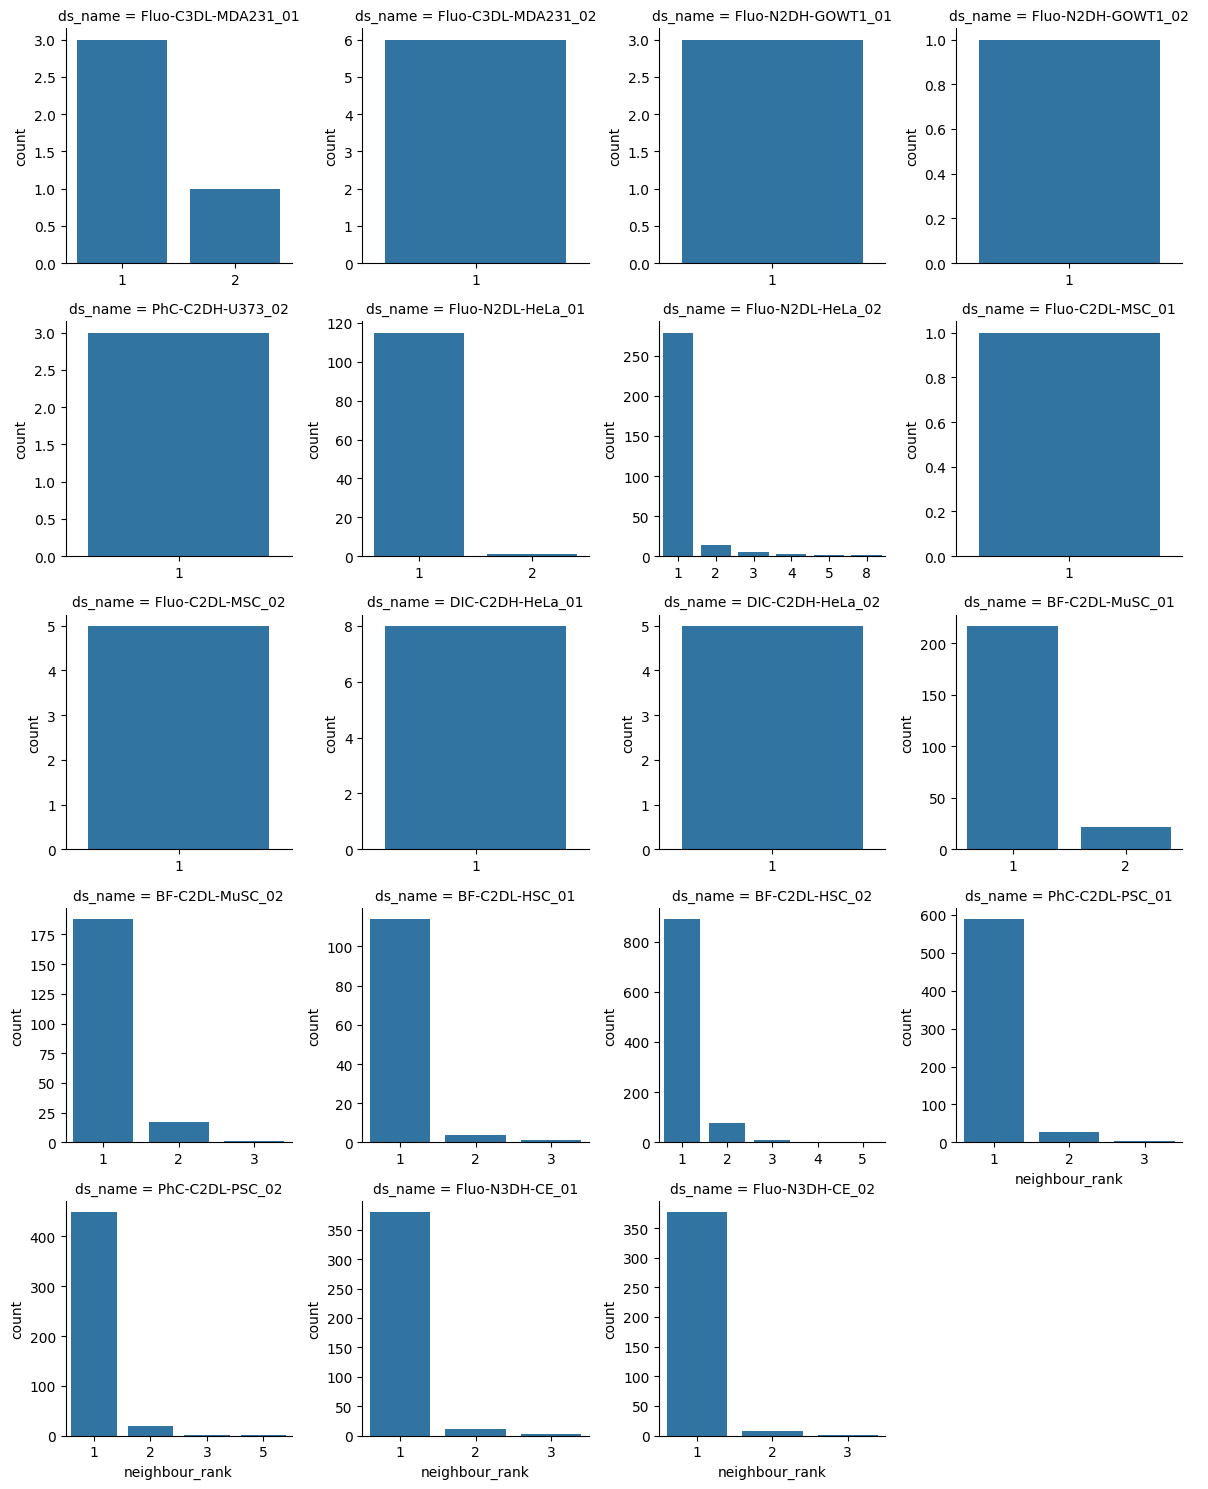

In [22]:
import seaborn as sns

grid = sns.FacetGrid(gt_neighbour_rank_df[gt_neighbour_rank_df['neighbour_rank'] > 0], col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True)
grid.map_dataframe(sns.countplot, x='neighbour_rank')
grid.add_legend()

In [23]:
# investigating division costs as prop. of migration cost

# cost of correct vs. incorrect edges for divisions vs. migration
import networkx as nx
import numpy as np
import os
from tracktour._tracker import VirtualVertices

chosen_cost_dict = {
    'ds_name': [],
    'div_parent_index': [],
    'is_superparent': [],
    'modified_cost': [],
    'division_cost': [],
    'chosen_children_dist': [],
    # 'cheating_false', 'cheating_true', 'valid_false', 'valid_true'
    'category': [],
}
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_solution.graphml')
    all_edges_path = os.path.join(SOL_ROOT, ds_name, 'all_edges.csv')

    sol_g = nx.read_graphml(solution_path, node_type=int)
    all_edges_path = os.path.join(SOL_ROOT, ds_name, 'all_edges.csv')
    location_cols = ['z', 'y', 'x'] if 'z' in sol_g.nodes[0] else ['y', 'x']
    scale = scales[ds_name]['pixel_scale']

    divs = [node for node in sol_g.nodes if sol_g.out_degree(node) > 1]
    for div in divs:
        children = list(sol_g.successors(div))
        is_superparent = len(children) > 2
        is_correct = not any(sol_g.edges[(div, child)][EDGE_FP] or sol_g.edges[(div, child)][EDGE_WS] for child in children)
        parent_coords = np.asarray([sol_g.nodes[div][col] * scale[i] for i, col in enumerate(location_cols)])
        child_coords = [np.asarray([sol_g.nodes[child][col] * scale[i] for i, col in enumerate(location_cols)]) for child in children]
        distances = np.sort([np.linalg.norm(parent_coords - child) for child in child_coords])

        closest_children_dist = distances[0] + distances[1]
        div_edge = all_edges[(all_edges['u'] == VirtualVertices.DIV.value) & (all_edges['v'] == div)]
        div_cost = div_edge['cost'].values[0]
        is_valid = div_edge['flow'].values[0] > 0

        if is_valid:
            if is_correct:
                category = 'valid_true'
            else:
                category = 'valid_false'
        else:
            if is_correct:
                category = 'cheating_true'
            else:
                category = 'cheating_false'

        chosen_cost_dict['ds_name'].append(ds_name)
        chosen_cost_dict['div_parent_index'].append(div)
        chosen_cost_dict['is_superparent'].append(is_superparent)
        # what division cost was incorrectly not chosen? i.e. the false div cost of merged divs?
        chosen_cost_dict['modified_cost'].append(div_cost if is_valid else closest_children_dist)
        chosen_cost_dict['division_cost'].append(div_cost)
        chosen_cost_dict['chosen_children_dist'].append(closest_children_dist)
        chosen_cost_dict['category'].append(category)

chosen_cost_df = pd.DataFrame(chosen_cost_dict)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
import seaborn as sns

grid = sns.FacetGrid(chosen_cost_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='category')
grid.map_dataframe(sns.scatterplot, x='modified_cost', y='chosen_children_dist')
grid.add_legend()

In [ ]:
import seaborn as sns

grid = sns.FacetGrid(chosen_cost_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='category')
grid.map_dataframe(sns.scatterplot, x='division_cost', y='chosen_children_dist', alpha=0.4)
grid.add_legend()

In [ ]:
import seaborn as sns

chosen_cost_df['is_correct'] = chosen_cost_df.category.str.contains('true')
chosen_cost_df['is_valid'] = chosen_cost_df.category.str.contains('valid')
grid = sns.FacetGrid(chosen_cost_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='is_correct')
grid.map_dataframe(sns.scatterplot, x='division_cost', y='chosen_children_dist', alpha=0.4)
grid.add_legend()

In [ ]:
grid = sns.FacetGrid(chosen_cost_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='is_valid')
grid.map_dataframe(sns.scatterplot, x='division_cost', y='chosen_children_dist', alpha=0.3)
grid.add_legend()

In [ ]:
solution_path = os.path.join(SOL_ROOT, 'Fluo-N3DH-CE_02', 'matched_solution.graphml')
all_edges_path = os.path.join(SOL_ROOT, 'Fluo-N3DH-CE_02', 'all_edges.csv')

sol_g = nx.read_graphml(solution_path, node_type=int)
all_edges = pd.read_csv(all_edges_path)

In [ ]:
# structural property of tracks - mergeless tracks
from collections import defaultdict
import os
import networkx as nx

all_components = dict()
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_solution.graphml')
    all_edges_path = os.path.join(SOL_ROOT, ds_name, 'all_edges.csv')

    sol_g = nx.read_graphml(solution_path, node_type=int)
    all_edges = pd.read_csv(all_edges_path)

    undirected_g = sol_g.to_undirected()
    components = defaultdict(dict)
    for i, component in enumerate(nx.connected_components(undirected_g)):
        components[i]['nodes'] = component
        components[i]['edges'] = list(sol_g.subgraph(component).edges)
        components[i]['total_edges'] = len(components[i]['edges'])
        components[i]['count_nodes'] = len(component)

        has_merges = [sol_g.in_degree(node) > 1 for node in component]
        count_merges = sum(has_merges)
        components[i]['has_merge'] = count_merges > 0
        components[i]['count_merges'] = count_merges

        has_divisions = [sol_g.out_degree(node) > 1 for node in component]
        count_divisions = sum(has_divisions)
        components[i]['has_division'] = count_divisions > 0
        components[i]['count_divisions'] = count_divisions

        wrong_edge = [(sol_g.edges[edge][EDGE_FP] or sol_g.edges[edge][EDGE_WS]) for edge in components[i]['edges']]
        components[i]['count_wrong_edges'] = wrong_edge.count(True)
        components[i]['count_correct_edges'] = wrong_edge.count(False)
        components[i]['is_correct'] = components[i]['count_correct_edges'] == components[i]['total_edges']
    all_components[ds_name] = components

In [ ]:
# ds_name, component_id, has_merge, is_fully_correct, prop_correct_edges
ds_names = []
comp_ids = []
has_merge = []
count_merge = []
has_div = []
count_div = []
is_fully_correct = []
prop_correct_edges = []
total_edges = []
for ds_name, comp_info in all_components.items():
    for comp_id, comp in comp_info.items():
        ds_names.append(ds_name)
        comp_ids.append(comp_id)
        has_merge.append(comp['has_merge'])
        count_merge.append(comp['count_merges'])
        has_div.append(comp['has_division'])
        count_div.append(comp['count_divisions'])
        is_fully_correct.append(comp['is_correct'])
        if comp['total_edges']> 0:
            prop_correct_edges.append(comp['count_correct_edges']/comp['total_edges'])
        else:
            prop_correct_edges.append(0)
        total_edges.append(comp['total_edges'])
component_df = pd.DataFrame({
    'ds_name': ds_names,
    'component': comp_ids,
    'has_merge': has_merge,
    'count_merges': count_merge,
    'has_div': has_div,
    'count_div': count_div,
    'is_correct': is_fully_correct,
    'prop_correct': prop_correct_edges,
    'total_edges': total_edges
})
    

In [ ]:
import os
import networkx as nx
import numpy as np
from tracktour._tracker import VirtualVertices

ds_names = []
node_ids = []
node_areas = []
comp_ids = []
# true if component contains a merge
merge_comp = []
# true if component contains a div
div_comp = []
# true if component is entirely correct
is_correct_comp = []
# true if node is a parent of a division
is_parent = []
# true if node is a parent of 3+ children
is_superparent = []
# true if the node has two incoming edges
is_merge_vertex = []
# -1 if node is not a parent, otherwise difference in distance to (two closest) children
child_distance_difference = []
# -1 if node is not a parent, otherwise sum of distances to (two closest) children
child_distance_sum = []
# -1 if node is not a parent, otherwise distance between two closest children
interchild_distance = []
# -1 if node is not a parent, otherwise angle between two closest children
# arcos of dot product of vectors from parent to children scaled by product of magnitudes
div_angle = []
# True if node is parent and both children are correct, otherwise False
div_correct = []
# True if node is parent and there is division flow into node
div_valid = []
# -1 if node has no successors, otherwise distance rank of the first child
first_chosen_neighbour_rank = []
# -1 if node is not a parent, otherwise distance rank of the second child
second_chosen_neighbour_rank = []
# -1 if node has no successors, otherwise distance to the closest child
first_child_distance = []
# -1 if node is not a parent, otherwise distance to the second closest child
second_child_distance = []
# -1 if node has no successors, otherwise area of the first child
first_child_area = []
# -1 if node is not a parent, otherwise area of the second child
second_child_area = []
# sum of areas of two children if node is parent, otherwise -1
child_area_sum = []
# cost of the Dv edge for node v (regardless of whether it was used)
div_cost = []
# True if node is not a parent, and the edge to its child is correct, otherwise False
mig_correct = []
for _, row in ds_summary.iterrows():
    ds_name = row['ds_name']
    det_path = row['det_path']
    solution_path = os.path.join(SOL_ROOT, ds_name, 'matched_solution.graphml')
    all_edges_path = os.path.join(SOL_ROOT, ds_name, 'all_edges.csv')

    sol_g = nx.read_graphml(solution_path, node_type=int)
    all_edges = pd.read_csv(all_edges_path)
    det_df = pd.read_csv(det_path)
    location_cols = ['z', 'y', 'x'] if 'z' in sol_g.nodes[0] else ['y', 'x']
    scale = scales[ds_name]['pixel_scale']

    ds_components = all_components[ds_name]
    for comp_id, comp in ds_components.items():
        for node in comp['nodes']:
            ds_names.append(ds_name)
            node_ids.append(node)
            node_areas.append(det_df.loc[node].area)
            comp_ids.append(comp_id)
            merge_comp.append(comp['has_merge'])
            div_comp.append(comp['has_division'])
            is_correct_comp.append(comp['is_correct'])
            is_parent.append(sol_g.out_degree(node) > 1)
            is_superparent.append(sol_g.out_degree(node) > 2)
            is_merge_vertex.append(sol_g.in_degree(node) > 1)

            children = list(sol_g.successors(node))
            parent_coords = np.asarray([sol_g.nodes[node][col] * scale[i] for i, col in enumerate(location_cols)])
            child_coords = [np.asarray([sol_g.nodes[child][col] * scale[i] for i, col in enumerate(location_cols)]) for child in children]
            child_distances = [np.linalg.norm(parent_coords - child) for child in child_coords]
            dist_indices = np.argsort(child_distances)
            children = [children[i] for i in dist_indices]
            closest_children = [child_coords[i] for i in dist_indices]
            distances = [child_distances[i] for i in dist_indices]

            child_dist_diff = -1
            child_dist_sum = -1
            ichild_dist = -1
            ang = -1
            first_neighb = -1
            second_neighb = -1
            first_dist = -1
            second_dist = -1
            first_area = -1
            second_area = -1
            area_sum = -1
            div_cos = -1
            div_corr = False
            div_val = False
            mig_corr = False
            if len(children) > 0:
                # save first child stuff
                other_edges = all_edges[(all_edges['u'] == node) & (all_edges['v'] >= 0)].sort_values(by='distance').reset_index()
                neighbour_ranks = [other_edges[other_edges['v'] == dest].index[0] for dest in children]
                first_neighb = neighbour_ranks[0]
                first_dist = distances[0]
                first_area = det_df.loc[children[0]].area
                if len(children) == 1:
                    mig_corr = (not (sol_g.edges[(node, children[0])][EDGE_FP] or sol_g.edges[(node, children[0])][EDGE_WS]))
                else:
                    ang = np.degrees(np.arccos(
                        np.dot(closest_children[0] - parent_coords, closest_children[1] - parent_coords) /
                        (distances[0] * distances[1])
                    ))
                    div_corr = not any(sol_g.edges[(node, child)][EDGE_FP] or sol_g.edges[(node, child)][EDGE_WS] for child in children)
                    second_neighb = neighbour_ranks[1]
                    second_dist = distances[1]
                    second_area = det_df.loc[children[1]].area
                    area_sum = first_area + second_area
                    child_dist_diff = distances[1] - distances[0]
                    child_dist_sum = distances[1] + distances[0]
                    ichild_dist = np.linalg.norm(closest_children[0] - closest_children[1])
                    div_edge = all_edges[(all_edges['u'] == VirtualVertices.DIV.value) & (all_edges['v'] == node)]
                    if len(div_edge):
                        div_cos = div_edge['cost'].values[0]
                        div_val = div_edge['flow'].values[0] > 0
            child_distance_difference.append(child_dist_diff)
            child_distance_sum.append(child_dist_sum)
            interchild_distance.append(ichild_dist)
            div_angle.append(ang)
            child_area_sum.append(area_sum)
            first_chosen_neighbour_rank.append(first_neighb)
            second_chosen_neighbour_rank.append(second_neighb)
            first_child_distance.append(first_dist)
            first_child_area.append(first_area)
            second_child_distance.append(second_dist)
            second_child_area.append(second_area)
            div_cost.append(div_cos)
            div_correct.append(div_corr)
            div_valid.append(div_val)
            mig_correct.append(mig_corr)
all_node_info = pd.DataFrame({
    'ds_name': ds_names,
    'node_id': node_ids,
    'node_area': node_areas,
    'component_id': comp_ids,
    'comp_merge': merge_comp,
    'comp_div': div_comp,
    'comp_correct': is_correct_comp,
    'is_parent': is_parent,
    'is_superparent': is_superparent,
    'is_merge_vertex': is_merge_vertex,
    'child_distance_difference': child_distance_difference,
    'child_distance_sum': child_distance_sum,
    'interchild_distance': interchild_distance,
    'div_angle': div_angle,
    'child_area_sum': child_area_sum,
    'div_correct': div_correct,
    'div_valid': div_valid,
    'first_chosen_neighbour_rank': first_chosen_neighbour_rank,
    'second_chosen_neighbour_rank': second_chosen_neighbour_rank,
    'first_child_distance': first_child_distance,
    'first_child_area': first_child_area,
    'second_child_distance': second_child_distance,
    'second_child_area': second_child_area,
    'div_cost': div_cost,
    'mig_correct': mig_correct
})
# all_node_info.to_csv(os.path.join(SOL_ROOT, 'all_node_info.csv'), index=False)

In [ ]:
import seaborn as sns

grid = sns.FacetGrid(component_df, col='ds_name', col_wrap=4, sharex=True, sharey=False, legend_out=True, hue='has_merge')
grid.map_dataframe(sns.countplot, x='is_correct')
grid.add_legend()

In [ ]:
import seaborn as sns

grid = sns.FacetGrid(component_df[component_df.has_merge == False], col='ds_name', col_wrap=4, sharex=True, sharey=False, legend_out=True, hue='has_div')
grid.map_dataframe(sns.countplot, x='is_correct')
grid.add_legend()

In [ ]:
grid = sns.FacetGrid(component_df[(component_df.has_div == False) & (component_df.has_merge == False)], col='ds_name', col_wrap=4, sharex=True, sharey=False, legend_out=True)
grid.map_dataframe(sns.countplot, x='is_correct')
grid.add_legend()

In [ ]:
grid = sns.FacetGrid(component_df[(component_df.has_div == True) & (component_df.has_merge == False)], col='ds_name', col_wrap=4, sharex=True, sharey=False, legend_out=True)
grid.map_dataframe(sns.countplot, x='is_correct')
grid.add_legend()

In [ ]:
import seaborn as sns

grid = sns.FacetGrid(component_df, col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='has_merge')
grid.map_dataframe(sns.histplot, x='total_edges')
grid.add_legend()

In [ ]:
import seaborn as sns

grid = sns.FacetGrid(component_df[component_df['total_edges'] > 0], col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='has_merge')
grid.map_dataframe(sns.scatterplot, x='total_edges', y='prop_correct')
grid.add_legend()

What else do we want to know about merge vs. mergeless components

- num divisions (correct/incorrect)
- division asymmetry coloured by correct/incorrect merge/mergeless
- angle of division coloured by correct/incorrect merge/mergeless
- sum of cell area vs. parent area coloured by correct/incorrect
- would be good to learn a migration measure from tracks with no divisions
    - how many of these've we got?
- distance from borders?
- specifically looking for discriminators within the mergeless components

In [ ]:
all_info_df = pd.read_csv(os.path.join(SOL_ROOT, 'all_node_info.csv'))

In [ ]:
all_info_df['child_area_prop'] = np.where(all_info_df['child_area_sum'] > 0, all_info_df['child_area_sum'] / all_info_df['node_area'], -1)
all_info_df['neighbour_rank_difference'] = np.where(all_info_df['second_chosen_neighbour_rank'] >= 0, all_info_df['second_chosen_neighbour_rank'] - all_info_df['first_chosen_neighbour_rank'], -1)
all_info_df['neighbour_rank_sum'] = np.where(all_info_df['second_chosen_neighbour_rank'] >= 0, all_info_df['second_chosen_neighbour_rank'] + all_info_df['first_chosen_neighbour_rank'], -1)

In [ ]:
all_info_df.to_csv(os.path.join(SOL_ROOT, 'all_node_info.csv'), index=False)

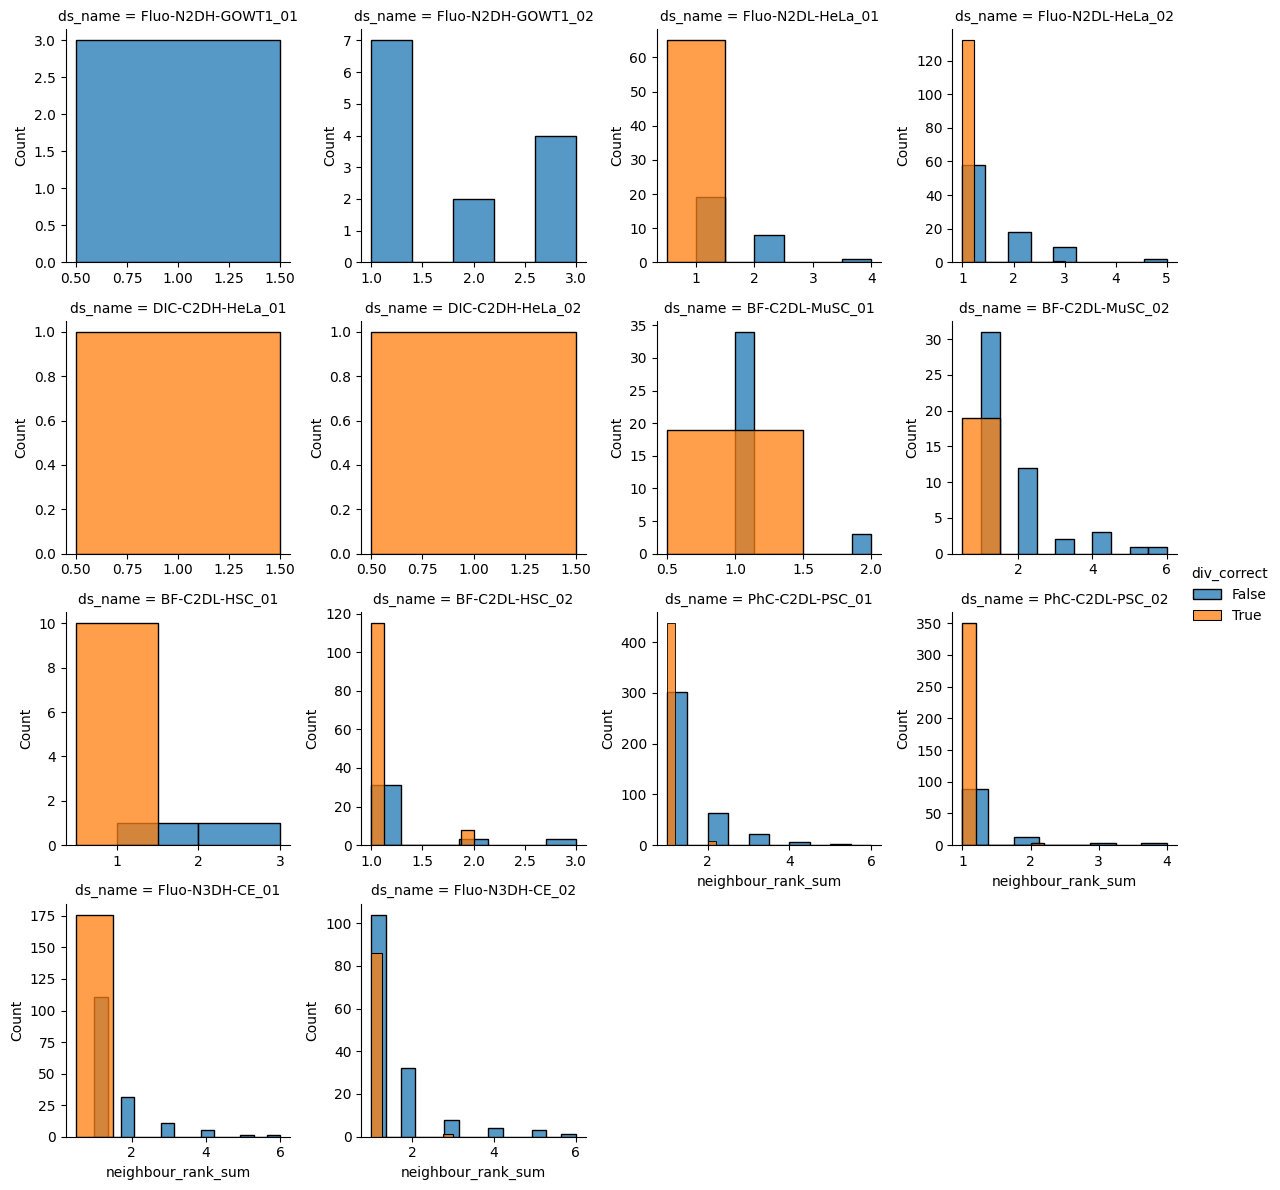

In [ ]:
import seaborn as sns

grid = sns.FacetGrid(all_info_df[all_info_df.is_parent], col='ds_name', col_wrap=4, sharex=False, sharey=False, legend_out=True, hue='div_correct')
grid.map_dataframe(sns.histplot, x='neighbour_rank_sum')
grid.add_legend()

In [ ]:
all_info_df[all_info_df.first_child_distance >= 0].value_counts('mig_correct')

mig_correct
True     296993
False      4995
Name: count, dtype: int64

In [ ]:
all_info_df[all_info_df.second_child_distance >= 0].value_counts('div_correct')

div_correct
True     1435
False    1074
Name: count, dtype: int64